# Examine (anti-)correlation of `h` and wind stress (Figure 5)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pylab as pylab

In [2]:
import numpy as np
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar

In [3]:
# Filter Specs
filter_fac = 32  

run = 'nw2_0.03125deg_N15_baseline_hmix20'
basepath = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
workpath = '/glade/work/noraloose/' 

In [4]:
st = xr.open_dataset('%s/%s/static.nc' % (basepath,run), decode_times=False)

In [6]:
# for depth-integrated 500 day averages
ds_lorenz_averaged = xr.open_dataset('%s/%s/lorenz_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)
ds_bleck_averaged = xr.open_dataset('%s/%s/bleck_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)

# for 3D wind work diagnostics
nr_days = 500

filename_s = '%s/%s/wind_work_diags_spatial_fac%i_%idays.nc' %(workpath, run, filter_fac, nr_days)
filename_t = '%s/%s/wind_work_diags_temporal_500days.nc' %(workpath, run)
ds_spatial = xr.open_dataset(filename_s)
ds_temporal = xr.open_dataset(filename_t)

In [8]:
# for examining the correlations in unfiltered data
chunks = {'time': 1}
av = xr.open_mfdataset('%s/%s/averages_*.nc' % (basepath, run), decode_times=False, chunks=chunks, combine='by_coords')
av = av.isel(time=slice(-100, None))  # pick the same 500 days of data that have been analyzed throughout this work
av.time

<xarray.DataArray 'time' (time: 100)>
array([2402.5, 2407.5, 2412.5, 2417.5, 2422.5, 2427.5, 2432.5, 2437.5, 2442.5,
       2447.5, 2452.5, 2457.5, 2462.5, 2467.5, 2472.5, 2477.5, 2482.5, 2487.5,
       2492.5, 2497.5, 2502.5, 2507.5, 2512.5, 2517.5, 2522.5, 2527.5, 2532.5,
       2537.5, 2542.5, 2547.5, 2552.5, 2557.5, 2562.5, 2567.5, 2572.5, 2577.5,
       2582.5, 2587.5, 2592.5, 2597.5, 2602.5, 2607.5, 2612.5, 2617.5, 2622.5,
       2627.5, 2632.5, 2637.5, 2642.5, 2647.5, 2652.5, 2657.5, 2662.5, 2667.5,
       2672.5, 2677.5, 2682.5, 2687.5, 2692.5, 2697.5, 2702.5, 2707.5, 2712.5,
       2717.5, 2722.5, 2727.5, 2732.5, 2737.5, 2742.5, 2747.5, 2752.5, 2757.5,
       2762.5, 2767.5, 2772.5, 2777.5, 2782.5, 2787.5, 2792.5, 2797.5, 2802.5,
       2807.5, 2812.5, 2817.5, 2822.5, 2827.5, 2832.5, 2837.5, 2842.5, 2847.5,
       2852.5, 2857.5, 2862.5, 2867.5, 2872.5, 2877.5, 2882.5, 2887.5, 2892.5,
       2897.5])
Coordinates:
  * time     (time) float64 2.402e+03 2.408e+03 ... 2.892e+03 2.898e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS
    bounds:          time_bnds

## Prepare NW2 grid information

In [9]:
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
         }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y')

## Plotting

In [10]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [11]:
extent = [0, 60, -70, -20] # regional

In [12]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']
plt.rcParams['text.usetex'] = False

/glade/scratch/noraloose/ipykernel_281636/3217311076.py:1: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']


### First row of figure

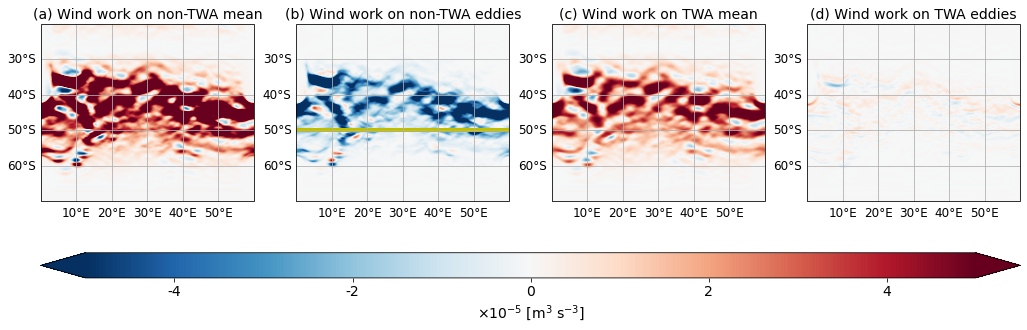

In [15]:
lat = -50
vmax = 0.00005
vmin = -vmax
title_fontsize = 14

ds_list = [ds_lorenz_averaged, ds_lorenz_averaged, ds_bleck_averaged, ds_bleck_averaged]
name_list = ['MKE_wind_stress', 'EKE_wind_stress', 'MKE_wind_stress_TWA', 'EKE_wind_stress_TWA']
label_list = [
    '(a) Wind work on non-TWA mean',
    '(b) Wind work on non-TWA eddies',
    '(c) Wind work on TWA mean',
    '(d) Wind work on TWA eddies'
]


fig, axs = plt.subplots(1,4,figsize=(17,5),subplot_kw={'projection':ccrs.PlateCarree()})

for ds, name, lb, ax in zip(ds_list, name_list, label_list, axs):
    fld_plot = ds[name]

    p = fld_plot.plot(
        ax=ax, 
        vmax=vmax, vmin=vmin, cmap='RdBu_r',
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    ) 
    ax.set_title(lb, fontsize=title_fontsize)

    
axs[1].hlines(lat, 0, 60, color='y', linewidth=4)

for ax in axs:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

# colorbar
fig.subplots_adjust(left=0.1, bottom=0.02)
cax = fig.add_axes([0.1, -0.01, 0.8, 0.07])
cb = fig.colorbar(p, cax=cax, extend='both', orientation='horizontal',
                  ticks=1e-5*np.arange(-4,5,2))
cb.ax.tick_params(labelsize=14)
cb.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]',size=14)#, y=0.45)
cb.ax.set_xticklabels(['-4','-2','0','2','4'])

figname = 'figures/wind_work_1_fac%i.png' %filter_fac
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### Second row of figure

In [16]:
ds_spatial['e_x'] = grid.interp(ds_spatial['e'], 'X')
ds_temporal['e_x'] = grid.interp(ds_temporal['e'], 'X')

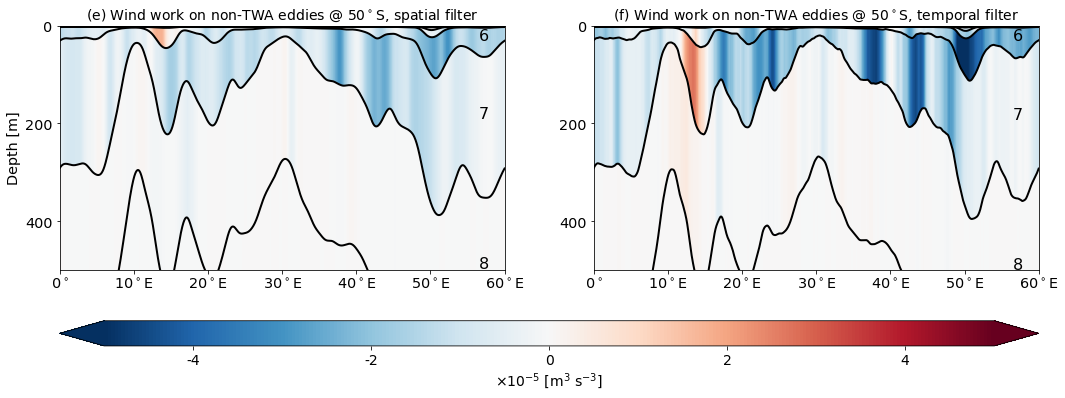

In [17]:
vmax = 0.00005
vmin = -vmax

lat = -50
title_fontsize = 14

fld_list = ['EKE_wind_stress', 'EKE_wind_stress']
ds_list = [ds_spatial, ds_temporal]
label_list = [r'(e) Wind work on non-TWA eddies @ 50$^\circ$S, spatial filter',
              r'(f) Wind work on non-TWA eddies @ 50$^\circ$S, temporal filter']
units = r'm$^2$s$^{-3}$'

fig, axs = plt.subplots(1,2,figsize=(17,5))

for ax, fld, ds_plot, label  in zip(axs, fld_list, ds_list, label_list):
        
    for i in range(10):   
        ax.plot(st.xh, ds_plot.e.isel(zi=i).sel(yh=lat, method="nearest"), linewidth=2, color='k')

    p = ax.pcolormesh(
        st.xq, ds_plot.e_x.fillna(value=0).isel(zi=slice(None,10)).sel(yh=lat, method="nearest"), 
        ds_plot[fld].isel(zl=slice(None,9)).sel(yh=lat, method="nearest"), 
        vmin=-vmax, vmax=vmax, cmap='RdBu_r'
    )
    ax.set_title(label, fontsize=title_fontsize)
    
    # layer labels
    for i in range(5, 8):
        lon_pos = 56.5
        # draw label
        z_pos = (
            0.55 * ds_plot.e.isel(zi=i).sel(yh=lat, xh=lon_pos, method='nearest')
            + 0.45 * ds_plot.e.isel(zi=i+1).sel(yh=lat, xh=lon_pos, method='nearest')
        )
        ax.text(lon_pos, z_pos, '%i' %(i+1), fontsize=16)
    ax.set_ylim([-500,0])
    ax.set_xticks(ticks=np.arange(0, 60.01, 10))
    ax.set(xticklabels=[r'0$^\circ$', r'10$^\circ$E', r'20$^\circ$E',  r'30$^\circ$E',  r'40$^\circ$E', r'50$^\circ$E', r'60$^\circ$E'])
    ax.set_yticks(ticks=np.arange(-400, 0.01, 200))
    ax.set(yticklabels=[400, 200, 0])
    ax.set_ylabel('')

axs[0].set_ylabel('Depth [m]')    

# colorbar
fig.subplots_adjust(left=0.1, bottom=0.2)
cax = fig.add_axes([0.1, -0.01, 0.8, 0.07])
cb = fig.colorbar(p, cax=cax, extend='both', orientation='horizontal', ticks=1e-5*np.arange(-4,5,2))
cb.ax.tick_params(labelsize=14)
cb.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]',size=14)#, y=0.45)
cb.ax.set_xticklabels(['-4','-2','0','2','4'])

figname = 'figures/wind_work_2_fac%i.png' %filter_fac
plt.savefig(figname,dpi=200, bbox_inches='tight', pad_inches=0)

### Third row

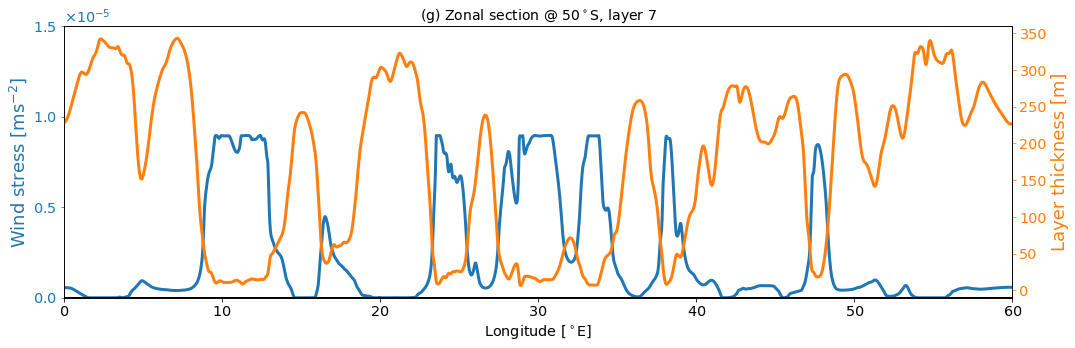

In [20]:
layer = 6
time = 10

fig, bigax = plt.subplots(1,1,figsize=(17,5))

color = 'tab:blue'
da = av.du_dt_str.isel(zl=layer, time=time).sel(yh=lat, method='nearest')
da.plot(ax=bigax, color=color, linewidth=3)
bigax.set_ylabel(r'Wind stress [ms$^{-2}$]', color=color, fontsize=18)
bigax.ticklabel_format(useMathText=True)
bigax.set_yticks(ticks=1e-5*np.arange(0, 1.6, 0.5))
bigax.tick_params(axis='y', colors=color)
bigax.set_ylim(0, 1.5e-5)
bigax.set_title('(g) Zonal section @ 50$^\circ$S, layer %i' %(layer+1), fontsize=title_fontsize)

bigax2=bigax.twinx()
color = 'tab:orange'
da = av.h.isel(zl=layer, time=time).sel(yh=lat, method='nearest')
da.plot(ax=bigax2, color=color, linewidth=3)
bigax2.set_ylabel(r'Layer thickness [m]', color=color, fontsize=18)
bigax2.tick_params(axis='y', colors=color)
bigax2.set_title('')

bigax.set_xlabel(r'Longitude [$^\circ$E]')
bigax.set_xlim(0, 60)  
bigax.hlines(0, 0, 60, color='k', linewidth=2)


plt.subplots_adjust(wspace=0.3, hspace=0.3)  
figname = 'figures/wind_h_correlations.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)